In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn

from matplotlib.lines import Line2D
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm, trange

from utils import PlotParams

plotter = PlotParams()
plotter.set_params()

if not os.path.exists('figs'):
    os.mkdir('figs')

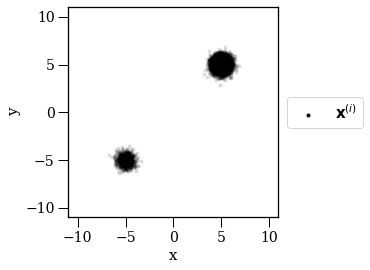

In [2]:
mu1 = np.array([5, 5])
sigma1 = np.array([[0.2, 0], [0, 0.2]])
X1 = np.random.multivariate_normal(mean=mu1, cov=sigma1, size=10000)

mu2 = np.array([-5, -5])
sigma2 = np.array([[0.2, 0], [0, 0.2]])
X2 = np.random.multivariate_normal(mean=mu2, cov=sigma2, size=1000)

X = np.concatenate([X1, X2])

plt.scatter(X[:-1, 0], X[:-1, 1], marker='.', color='k', alpha=0.1)
plt.scatter(X[-1, 0], X[-1, 1], marker='.', color='k', alpha=1.0, label=r'$\mathbf{x}^{(i)}$')#=\left(x^{(i)}, y^{(i)}\right)^{T}$')
plt.xlim(-11, 11)
plt.ylim(-11, 11)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig(os.path.join('figs', '1_data.png'), dpi=300)
plt.show()

In [3]:
dataset = TensorDataset(torch.tensor(X).float())
dataloader = DataLoader(dataset, batch_size=256, pin_memory=True, shuffle=True)

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16 ,2)
        )

    def forward(self, x):
        return self.model(x)

model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)
loss_fn = nn.MSELoss()

In [5]:
def get_noise(x, beta, sigmas=[1.0]):
    sigmas = torch.tensor(sigmas).float()
    if beta == 2.0:
        noise = sigmas * torch.randn_like(x, device=sigmas.device)
        score = - 1 / (sigmas ** 2) * noise
    else:
        alpha = 2 ** 0.5
        gamma = np.random.gamma(shape=1+1/beta, scale=2**(beta/2), size=x.shape)
        delta = alpha * gamma ** (1 / beta) / (2 ** 0.5)
        gn_samples = (2 * np.random.rand(*x.shape) - 1) * delta

        noise = sigmas * torch.tensor(gn_samples).float()
        constant = - beta / (sigmas * 2.0 ** 0.5) ** beta
        score = constant * torch.sign(noise) * torch.abs(noise) ** (beta - 1)

    return noise.to(x.device), score.to(x.device)

In [6]:
beta = 2.0
sigmas = [1.0, 0.25]

In [7]:
def weighted_mse_loss(input, target, weight):
    return torch.mean(weight * (input - target) ** 2)

In [8]:
max_iter = 1000
step = 0
losses = []
X_noised = []

with trange(max_iter, desc=f"Training progress") as t:
    for _ in range(9999):
        for x in dataloader:
            step += 1

            x = x[0].cuda()
            used_sigmas = np.random.choice(sigmas, (x.shape[0], 1))
            noise, score = get_noise(x, beta, sigmas=used_sigmas)
            x_noised = x + noise
            X_noised.append(x_noised.detach().cpu().numpy())

            score_estimate = model(x_noised)
            # loss = loss_fn(score_estimate, score)
            loss = weighted_mse_loss(score_estimate, score, weight=torch.tensor(used_sigmas, device=x.device))

            losses.append(loss.item())
            t.set_postfix(loss=loss.item())
            t.update()

            if step >= max_iter:
                break

            for p in model.parameters():
                p.grad = None
            loss.backward()
            optimizer.step()

        if step >= max_iter:
            break
X_noised = np.concatenate(X_noised)

Training progress:   0%|          | 0/1000 [00:00<?, ?it/s]

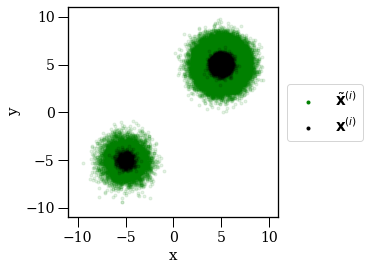

In [9]:
plt.scatter(X_noised[:-1, 0], X_noised[:-1, 1], marker='.', color='g', alpha=0.1)
plt.scatter(X_noised[-1, 0], X_noised[-1, 1], marker='.', color='g', alpha=1.0, label=r'$\tilde{\mathbf{x}}^{(i)}$')
plt.scatter(X[:-1, 0], X[:-1, 1], marker='.', color='k', alpha=0.1)
plt.scatter(X[-1, 0], X[-1, 1], marker='.', color='k', alpha=1.0, label=r'$\mathbf{x}^{(i)}$')
plt.xlim(-11, 11)
plt.ylim(-11, 11)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.gca().set_aspect('equal')
plt.tight_layout()
# plt.savefig(os.path.join('figs', '2_noised_data.png'), dpi=300)
# plt.savefig(os.path.join('figs', '2_noised_data_2level.png'), dpi=300)
# plt.savefig(os.path.join('figs', '2_noised_data_laplace.png'), dpi=300)
# plt.savefig(os.path.join('figs', '2_noised_data_2level_laplace.png'), dpi=300)
# plt.savefig(os.path.join('figs', '2_noised_data_2level_10x.png'), dpi=300)
plt.savefig(os.path.join('figs', '2_noised_data_2level_laplace_10x.png'), dpi=300)
plt.show()

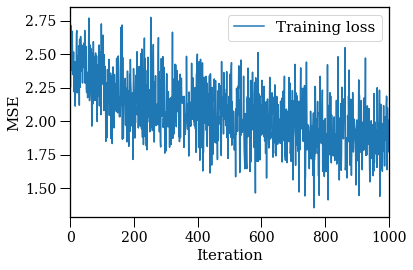

In [10]:
plt.plot(losses, label='Training loss')
plt.xlim(0, max_iter)
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
# plt.savefig(os.path.join('figs', '3_loss_curve.png'), dpi=300)
# plt.savefig(os.path.join('figs', '3_loss_curve.pdf'))
# plt.savefig(os.path.join('figs', '3_loss_curve_laplace.png'), dpi=300)
# plt.savefig(os.path.join('figs', '3_loss_curve_2level_laplace.png'), dpi=300)
# plt.savefig(os.path.join('figs', '3_loss_curve_2level_10x.png'), dpi=300)
plt.savefig(os.path.join('figs', '3_loss_curve_2level_laplace_10x.png'), dpi=300)
plt.show()

In [11]:
model.eval()

n_points = 10
ld_iters = 1000
grad_arr = np.zeros((n_points, ld_iters*len(sigmas), 2))
path_arr = np.zeros((n_points, ld_iters*len(sigmas), 2))
eps = 0.1
x = 12 * np.random.rand(n_points, 2) - 6
i = 0
path_arr[:, i, :] = x

with torch.no_grad():
    for level, sigma in enumerate(sigmas):
        for _ in tqdm(range(ld_iters)):
            i += 1

            x_tensor = torch.tensor(x).float().cuda()
            used_sigmas = np.random.choice([sigma], (x_tensor.shape[0], 1))
            noise = get_noise(x_tensor, beta=1.0, sigmas=used_sigmas)[0]
            noise = noise.cpu().detach().numpy()

            du = model(x_tensor).cpu().detach().numpy()
            x += eps * du + np.sqrt(2 * eps) * noise

            if i == (len(sigmas) * ld_iters):
                break
            else:
                grad_arr[:, i, :] = du
                path_arr[:, i, :] = x

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
dist1 = np.sum((path_arr - mu1) ** 2, axis=2) ** 0.5
dist2 = np.sum((path_arr - mu2) ** 2, axis=2) ** 0.5
close_to_1 = dist1 < dist2
close_to_2 = ~close_to_1

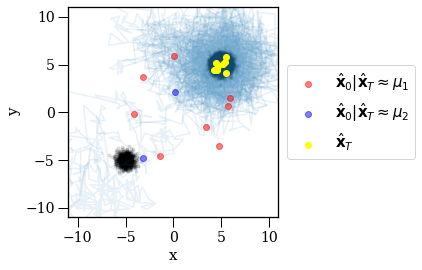

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(X[:, 0], X[:, 1], marker='.', color='k', alpha=0.1)
for i in range(n_points):
    ax.add_line(Line2D(path_arr[i, :, 0], path_arr[i, :, 1], alpha=0.1))
plt.scatter(path_arr[close_to_1[:, -1], 0, 0], path_arr[close_to_1[:, -1], 0, 1], color='red', marker='o', label=r'$\hat{\mathbf{x}}_{0}|\hat{\mathbf{x}}_{T}\approx\mu_{1}$', alpha=0.5, zorder=100)
plt.scatter(path_arr[close_to_2[:, -1], 0, 0], path_arr[close_to_2[:, -1], 0, 1], color='blue', marker='o', label=r'$\hat{\mathbf{x}}_{0}|\hat{\mathbf{x}}_{T}\approx\mu_{2}$', alpha=0.5, zorder=100)
# plt.scatter(path_arr[close_to_1[:, -1], 0, 0], path_arr[close_to_1[:, -1], 0, 1], color='red', marker='o', label=f'{close_to_1[:, -1].sum()}/{n_points}', alpha=0.5, zorder=100)
# plt.scatter(path_arr[close_to_2[:, -1], 0, 0], path_arr[close_to_2[:, -1], 0, 1], color='blue', marker='o', label=f'{close_to_2[:, -1].sum()}/{n_points}', alpha=0.5, zorder=100)
plt.scatter(path_arr[:, -1, 0], path_arr[:, -1, 1], color='yellow', marker='o', label=r'$\hat{\mathbf{x}}_{T}$', zorder=1000000)
plt.xlim(-11, 11)
plt.ylim(-11, 11)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.gca().set_aspect('equal')
plt.tight_layout()
# plt.savefig(os.path.join('figs', '4_paths.png'), dpi=300)
# plt.savefig(os.path.join('figs', '4_paths_2level.png'), dpi=300)
# plt.savefig(os.path.join('figs', '4_paths_laplace.png'), dpi=300)
# plt.savefig(os.path.join('figs', '4_paths_2level_laplace.png'), dpi=300)
# plt.savefig(os.path.join('figs', '4_paths_2level_10x.png'), dpi=300)
plt.savefig(os.path.join('figs', '4_paths_2level_laplace_10x.png'), dpi=300)
plt.show()

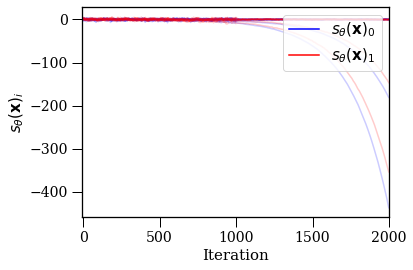

In [14]:
for i in range(n_points-1):
    plt.plot(grad_arr[i, 1:, 0].T, 'b-', alpha=0.2)
plt.plot(grad_arr[-1, 1:, 0].T, 'b-', alpha=0.2, label=r'$s_{\theta}(\mathbf{x})_{0}$')
for i in range(n_points-1):
    plt.plot(grad_arr[i, 1:, 1].T, 'r-', alpha=0.2)
plt.plot(grad_arr[-1, 1:, 1].T, 'r-', alpha=0.2, label=r'$s_{\theta}(\mathbf{x})_{1}$')
plt.xlim(-10, ld_iters * len(sigmas))
plt.xlabel('Iteration')
plt.ylabel(r'$s_{\theta}(\mathbf{x})_{i}$')
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.tight_layout()
# plt.savefig(os.path.join('figs', '5_gradients.png'), dpi=300)
# plt.savefig(os.path.join('figs', '5_gradients_2level.png'), dpi=300)
# plt.savefig(os.path.join('figs', '5_gradients_laplace.png'), dpi=300)
# plt.savefig(os.path.join('figs', '5_gradients_2level_laplace.png'), dpi=300)
# plt.savefig(os.path.join('figs', '5_gradients_2level_10x.png'), dpi=300)
plt.savefig(os.path.join('figs', '5_gradients_2level_laplace_10x.png'), dpi=300)
plt.show()

In [15]:
model.eval()

n_points = 1000
ld_iters = 1000
grad_arr = np.zeros((n_points, ld_iters*len(sigmas), 2))
path_arr = np.zeros((n_points, ld_iters*len(sigmas), 2))
eps = 0.1
x = 12 * np.random.rand(n_points, 2) - 6
i = 0
path_arr[:, i, :] = x

with torch.no_grad():
    for level, sigma in enumerate(sigmas):
        for _ in tqdm(range(ld_iters)):
            i += 1

            x_tensor = torch.tensor(x).float().cuda()
            used_sigmas = np.random.choice([sigma], (x_tensor.shape[0], 1))
            noise = get_noise(x_tensor, beta=1.0, sigmas=used_sigmas)[0]
            noise = noise.cpu().detach().numpy()

            du = model(x_tensor).cpu().detach().numpy()
            x += eps * du + np.sqrt(2 * eps) * noise

            if i == (len(sigmas) * ld_iters):
                break
            else:
                grad_arr[:, i, :] = du
                path_arr[:, i, :] = x

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
dist1 = np.sum((path_arr - mu1) ** 2, axis=2) ** 0.5
dist2 = np.sum((path_arr - mu2) ** 2, axis=2) ** 0.5
close_to_1 = dist1 < dist2
close_to_2 = ~close_to_1

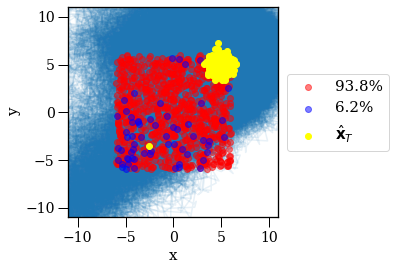

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(X[:, 0], X[:, 1], marker='.', color='k', alpha=0.1)
for i in range(n_points):
    ax.add_line(Line2D(path_arr[i, :, 0], path_arr[i, :, 1], alpha=0.1))
# plt.scatter(path_arr[close_to_1[:, -1], 0, 0], path_arr[close_to_1[:, -1], 0, 1], color='red', marker='o', label=r'$\hat{\mathbf{x}}_{1}|\hat{\mathbf{x}}_{T}\approx\mu_{1}$', alpha=0.5, zorder=100)
# plt.scatter(path_arr[close_to_2[:, -1], 0, 0], path_arr[close_to_2[:, -1], 0, 1], color='blue', marker='o', label=r'$\hat{\mathbf{x}}_{1}|\hat{\mathbf{x}}_{T}\approx\mu_{2}$', alpha=0.5, zorder=100)
plt.scatter(path_arr[close_to_1[:, -1], 0, 0], path_arr[close_to_1[:, -1], 0, 1], color='red', marker='o', label=f'{100*close_to_1[:, -1].sum()/n_points}%', alpha=0.5, zorder=100)
plt.scatter(path_arr[close_to_2[:, -1], 0, 0], path_arr[close_to_2[:, -1], 0, 1], color='blue', marker='o', label=f'{100*close_to_2[:, -1].sum()/n_points}%', alpha=0.5, zorder=100)
plt.scatter(path_arr[:, -1, 0], path_arr[:, -1, 1], color='yellow', marker='o', label=r'$\hat{\mathbf{x}}_{T}$', zorder=1000000)
plt.xlim(-11, 11)
plt.ylim(-11, 11)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.gca().set_aspect('equal')
plt.tight_layout()
# plt.savefig(os.path.join('figs', '6_more_paths.png'), dpi=300)
# plt.savefig(os.path.join('figs', '6_more_paths_2level.png'), dpi=300)
# plt.savefig(os.path.join('figs', '6_more_paths_laplace.png'), dpi=300)
# plt.savefig(os.path.join('figs', '6_more_paths_2level_laplace.png'), dpi=300)
# plt.savefig(os.path.join('figs', '6_more_paths_2level_10x.png'), dpi=300)
plt.savefig(os.path.join('figs', '6_more_paths_2level_laplace_10x.png'), dpi=300)
plt.show()